In [20]:
# Libraries

import matplotlib.pyplot as plt
import numpy as np
import math
import json

In [21]:
# trajectory

def pos2deg(ang):
    return int(360/4095.0*ang - 360.0/4)

def deg2pos(angle):
    return int(4095.0/360*angle + 4095.0/4)

def deg2rad(ang):
    return ang*math.pi/180


def list_of_angle(theta1,theta2, increase):
    """ input in deg but output in rad"""
    deg_trajectory = [*range(theta1, theta2, 1)]
    deg_trajectory_temp = [element*math.pi/180 for element in deg_trajectory]
    deg_trajectory = deg_trajectory_temp
    if increase:
        return deg_trajectory
    else:
        inv_deg_traj = []
        for i in range(len(deg_trajectory)-1,-1,-1):
            inv_deg_traj += [deg_trajectory[i]]
        return inv_deg_traj

# GEOMETRIC MODEL 

def norm2points(u,v):
    return math.sqrt((u[0]-v[0])**2+(u[1]-v[1])**2)

def model_rolling(theta_lf, a, b, c, d):
    e = math.sqrt(d**2 + a**2 - 2*a*d*math.cos(theta_lf))
    beta = math.acos((e**2 +d**2 - a**2)/(2*d*e))
    delta = math.acos((c**2 +e**2 - b**2)/(2*c*e))
    theta_rf = math.pi - (delta + beta)
    return theta_rf

# GENERATION OF THE SQUARE

def square_generation(p1,p2,diag):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p2p1 = p2 - p1
    u = p2p1/np.linalg.norm(p2p1)
    ## matrix orthogonal
    T = np.array([[0, -1],[1, 0]])
    ## orthogonal vector
    v = np.matmul(T,u)
    p3 = p1 + (diag/2)*(u+v)
    p4 = p1 + (diag/2)*(u-v)
    return [p3, p4]

def square_generation_side(p1,p2,side):
    """ up means that the contact point are the upper side of the square"""
    p1 = np.array(p1)
    p2 = np.array(p2)
    p2p1 = p2 - p1
    u = p2p1/np.linalg.norm(p2p1)
    ## matrix orthogonal
    T = np.array([[0, -1],[1, 0]])
    ## orthogonal vector
    v = np.matmul(T,u)
    p3 = p1 - side*v
    p4 = p2 - side*v
    return [p3, p4]

# GENERATION OF THE SQUARE

def corner_identification(pivot,p1,p2):
    """ cos(ang) = (p1-pivot).(p2-pivot)/norm"""
    v = np.array(p1) - np.array(pivot)
    u = np.array(p2)- np.array(pivot)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    angle = math.acos(np.dot(v,u)/(norm_u*norm_v))
    return angle > math.pi/2

In [22]:
# PLOTTING FUNCTIONS

def plot_scene(A,B,C,D,E,F,G,H):
        """ plotting """
        plt.figure()
        ax = plt.axes()
        ax.set_facecolor("gray")
        ### base
        plt.plot([0,D[0]],[0,0],'black',linewidth=5)
        ### fingers
        plt.plot([A[0],G[0]],[A[1],G[1]],linewidth=2,color='w')
        plt.plot([D[0],H[0]],[D[1],H[1]],linewidth=2,color='w')
        ## square
        plt.plot([B[0],C[0]],[B[1],C[1]],linewidth=2,color='black')
        plt.plot([B[0],E[0]],[B[1],E[1]],linewidth=2,color='black')
        plt.plot([B[0],F[0]],[B[1],F[1]],linewidth=2,color='black')
        plt.plot([C[0],E[0]],[C[1],E[1]],linewidth=2,color='black')
        plt.plot([C[0],F[0]],[C[1],F[1]],linewidth=2,color='black')
        plt.plot([E[0],F[0]],[E[1],F[1]],linewidth=2,color='black')
        ## pivot
        plt.plot(A[0],A[1],'o',markersize=5,color='blue')
        plt.plot(B[0],B[1],'o',markersize=5,color='orange')
        plt.plot(C[0],C[1],'o',markersize=5,color='orange')
        plt.plot(D[0],D[1],'o',markersize=5,color='blue')
        plt.plot(E[0],E[1],'o',markersize=5,color='orange')
        plt.plot(F[0],F[1],'o',markersize=5,color='orange')
        plt.xlim([-80,160])
        plt.ylim([-60,180])

def plot_pos_evol(thetaL,thetaR):
    """ plotting """
    thetaL = np.array(thetaL)[:,0].astype(float).tolist()
    thetaR = np.array(thetaR)[:,0].astype(float).tolist()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(thetaL, label = r'$\theta_L$')
    ax.plot(thetaR, label = r'$\theta_R$')
    leg1 = ax.legend(loc='upper right')
    plt.title("Fingers' Position - Rolling Manipulation")
    plt.ylabel('deg')
    plt.xlabel('time')
    plt.grid()

def plot_corner_side(thetaL,thetaR):
    """ plotting """
    temp_thetaL = np.array(thetaL)[:,0].astype(float).tolist()
    temp_thetaR = np.array(thetaR)[:,0].astype(float).tolist()
    corners = [[],[],[]]
    for i in range(len(thetaL)):
        if thetaL[i][1] == 'corner':
            corners[0] += [temp_thetaL[i]]
            corners[1] += [temp_thetaR[i]]
            corners[2] += [i]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(temp_thetaL, label = r'$\theta_L$')
    ax.plot(temp_thetaR, label = r'$\theta_R$')
    ax.scatter(corners[2],corners[0])
    ax.scatter(corners[2],corners[1])
    leg1 = ax.legend(loc='upper right')
    plt.ylabel('deg')
    plt.xlabel('time')
    plt.title("Corners and sides")
    plt.ylabel('deg')
    plt.xlabel('time')
    plt.grid()

In [97]:
# SIMULATION ALGORITHM
def ini_left_contact(face,c,d):
    """calculate the left contact point given that sqaure perpendicular to right finger """
    return math.sqrt((d-face)**2+(c+face)**2)

# WHEN THE SQUARE IS HANGING FROM CONSECUTIVE CORNER

def rolling_simulation_side(a, b, c, d, s, traj, forward):
    """s : diagonal in this case """
    keep_data = True
    list_theta_l = []
    list_theta_r = []
    len_finger = 132
    n = len(traj)
    for i in range(0,n):
        theta_pos = traj[i]
        A1 = [0, 0]
        D1 = [finger_gap, 0]
        if forward:
            theta_pos = math.pi - theta_pos
            theta_follow = model_rolling(theta_pos,c,b,a,d)
            theta_l = math.pi - theta_follow
            theta_r = math.pi - theta_pos
        else:
            theta_follow = model_rolling(theta_pos,a,b,c,d)
            theta_r = theta_follow
            theta_l = theta_pos
        B1 = [a*math.cos(theta_l), a*math.sin(theta_l)]
        C1 = [finger_gap + c*math.cos(theta_r), c*math.sin(theta_r)]
        # square
        [E1, F1] = square_generation_side(B1,C1, b)
        ### finger ends
        G1 = [len_finger*math.cos(theta_l), len_finger*math.sin(theta_l)]
        H1 = [finger_gap + len_finger*math.cos(theta_r), len_finger*math.sin(theta_r)]

        # if a corner is identified
        if corner_identification(B1,G1,C1):
            a = a-b
            [next_theta_l, next_theta_r, a, c] = rolling_simulation_diag(a, s, c, d, b, traj[i:-1], forward)
            list_theta_l[-1][1] ="corner"
            list_theta_l += next_theta_l
            list_theta_r[-1][1] ="corner"
            list_theta_r += next_theta_r
            keep_data = False
            break
        elif corner_identification(C1,B1,H1):
            c = c-b
            [next_theta_l, next_theta_r, a, c] = rolling_simulation_diag(a, s, c, d, b, traj[i:-1], forward)
            list_theta_l[-1][1] ="corner"
            list_theta_l += next_theta_l
            list_theta_r[-1][1] ="corner"
            list_theta_r += next_theta_r
            keep_data = False
            break
        # update list
        if keep_data:
            list_theta_l += [[theta_l,'side']]
            list_theta_r += [[theta_r,'side']]
            #list_theta_l += [[theta_l*180/math.pi,'side']]
            #list_theta_r += [[theta_r*180/math.pi,'side']]
        ### UNCOMMENT IF YOU WISH TO PLOT THE ANIMATION ###
        #plot_scene(A1,B1,C1,D1,E1,F1,G1,H1)
        ###################################################
    return [list_theta_l, list_theta_r, a, c]

# WHEN THE SQUARE IS HANGING FROM OPPOSITE CORNER

def rolling_simulation_diag(a, b, c, d, s, traj, forward):
    """a:left ; b:diag ; c:right ; d:bottom ; f:side"""
    keep_data = True
    list_theta_l = []
    list_theta_r = []
    len_finger = 132
    n = len(traj)
    for i in range(0,n):
        theta_pos = traj[i]
        A1 = [0, 0]
        D1 = [finger_gap, 0]
        if forward:
            theta_pos = math.pi - theta_pos
            theta_follow = model_rolling(theta_pos,c,b,a,d)
            theta_l = math.pi - theta_follow
            theta_r = math.pi - theta_pos
        else:
            theta_follow = model_rolling(theta_pos,a,b,c,d)
            theta_r = theta_follow
            theta_l = theta_pos
        B1 = [a*math.cos(theta_l), a*math.sin(theta_l)]
        C1 = [finger_gap + c*math.cos(theta_r), c*math.sin(theta_r)]
        # square
        [E1, F1] = square_generation(B1,C1, b)
        ### finger ends
        G1 = [len_finger*math.cos(theta_l), len_finger*math.sin(theta_l)]
        H1 = [finger_gap + len_finger*math.cos(theta_r), len_finger*math.sin(theta_r)]
        # if a corner is identified
        if corner_identification(C1,D1,F1):
            c = c+s
            [next_theta_l, next_theta_r, a, c] = rolling_simulation_side(a, s, c, d, b, traj[i:-1], forward)
            list_theta_l[-1][1] ="corner"
            list_theta_l += next_theta_l
            list_theta_r[-1][1] ="corner"
            list_theta_r += next_theta_r
            keep_data = False
            break
        elif corner_identification(B1,A1,F1):
            a = a+s
            [next_theta_l, next_theta_r, a, c] = rolling_simulation_side(a, s, c, d, b, traj[i:-1], forward)
            list_theta_l[-1][1] ="corner"
            list_theta_l += next_theta_l
            list_theta_r[-1][1] ="corner"
            list_theta_r += next_theta_r
            keep_data = False
            break
        # update list
        if keep_data:
            list_theta_l += [[theta_l,'side']]
            list_theta_r += [[theta_r,'side']]
            #list_theta_l += [[theta_l*180/math.pi,'side']]
            #list_theta_r += [[theta_r*180/math.pi,'side']]
        ### UNCOMMENT IF YOU WISH TO PLOT THE ANIMATION ###
        #plot_scene(A1,B1,C1,D1,E1,F1,G1,H1)
        ###################################################
    return [list_theta_l, list_theta_r, a, c]


def manipulation_simulation(sqrt_dim, ini_drf, gap, minang, maxang):
    ## initalisation
    clockwise = True
    increasing = True
    trajectory_increasing = list_of_angle(minang,maxang,increasing)
    trajectory_decreasing = list_of_angle(minang,maxang,not increasing)
    ## geometry
    sqrt_diag = math.sqrt(2)*sqrt_dim # square's diagonal
    drf = ini_drf
    dlf = ini_left_contact(sqrt_dim,ini_drf,gap) # bottom left finger to contact point
    ang90 = deg2rad(90)
    ## first clockwise motion
    trajectory = [element for element in trajectory_decreasing if element < ang90]
    [pos_l, pos_r, dlf, drf] = rolling_simulation_diag(dlf, sqrt_diag, drf, finger_gap, sqrt_dim, trajectory, clockwise)
    #### anticlockwise full motion
    new_trajectory_increasing = list_of_angle(minang-10,maxang,increasing)
    trajectory_increasing = [element for element in new_trajectory_increasing if element > pos_l[-1][0]]
    [pos_l1, pos_r1, dlf, drf] = rolling_simulation_diag(dlf, sqrt_diag, drf, finger_gap, sqrt_dim, trajectory_increasing, not clockwise)
    #### clockwise full motion
    new_trajectory_decreasing = list_of_angle(minang,maxang+10,not increasing)
    print(new_trajectory_decreasing)
    trajectory_decreasing = [element for element in new_trajectory_decreasing if element < pos_r1[-1][0]]
    [pos_l2, pos_r2, dlf, drf] = rolling_simulation_diag(dlf, sqrt_diag, drf, finger_gap, sqrt_dim, trajectory_decreasing, clockwise)
    ### final plot of the angle evolution
    plot_pos_evol(pos_l+pos_l1+pos_l2,pos_r+pos_r1+pos_r2)
    return [pos_l1,pos_r1,pos_l2,pos_r2]

# PERFORM SIMULATION 1

[2.251474735072685, 2.234021442552742, 2.2165681500327987, 2.199114857512855, 2.1816615649929116, 2.1642082724729685, 2.1467549799530254, 2.129301687433082, 2.111848394913139, 2.0943951023931953, 2.076941809873252, 2.0594885173533086, 2.0420352248333655, 2.0245819323134224, 2.007128639793479, 1.9896753472735356, 1.9722220547535922, 1.9547687622336491, 1.9373154697137058, 1.9198621771937625, 1.902408884673819, 1.8849555921538759, 1.8675022996339325, 1.8500490071139892, 1.8325957145940461, 1.8151424220741028, 1.7976891295541593, 1.780235837034216, 1.7627825445142729, 1.7453292519943295, 1.7278759594743864, 1.710422666954443, 1.6929693744344996, 1.6755160819145563, 1.6580627893946132, 1.6406094968746698, 1.6231562043547263, 1.605702911834783, 1.5882496193148399, 1.5707963267948966, 1.5533430342749535, 1.53588974175501, 1.5184364492350666, 1.5009831567151233, 1.4835298641951802, 1.4660765716752369, 1.4486232791552935, 1.43116998663535, 1.413716694115407, 1.3962634015954636, 1.3788101090755

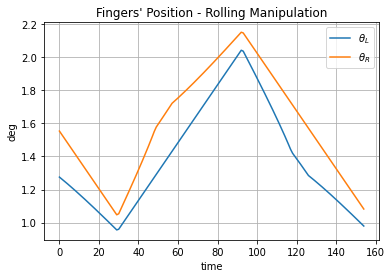

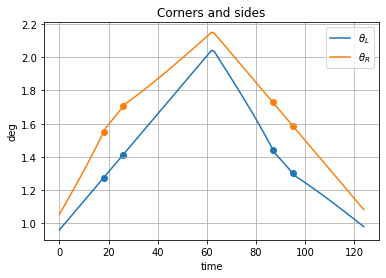

In [98]:
# INITIALIZATION
sqrt_side = 25
initial_drf = 60 # bottom right finger to contact point
finger_gap = 50 # width between fingers
min_ang = 60
max_ang = 120

# Perform the simulation
[data_pos_L1,data_pos_R1,data_pos_L2,data_pos_R2] = manipulation_simulation(sqrt_side, initial_drf, finger_gap, min_ang, max_ang)
plot_corner_side(data_pos_L1+data_pos_L2,data_pos_R1+data_pos_R2)

# STORE THE DATA  INTO A JSON FILE
data_pos_sim = {
    "LF_motion1": data_pos_L1,
    "RF_motion1": data_pos_R1,
    "LF_motion2": data_pos_L2,
    "RF_motion2": data_pos_R2,
}

In [ ]:
# STORE DATA
## INITIALIZE THE JSON FILE !!!!!!!!!

#with open("data_pos_sim_labelled_sep_motion.json", 'w') as f:
#    indent = 2  # is not needed but makes the file human-readable
#    json.dump(data_pos_sim, f, indent=2)

## ADD TO THE JSON FILE

#with open("data_pos.json", 'r+') as f:
#   # indent=2 is not needed but makes the file human-readable
#    data_pos_final = json.load(f)
#    data_pos_final.update(data_pos)
#    f.seek(0)
#    json.dump(data_pos_final, f, indent=2)

"""
        elif corner_identification(C1,H1,E1):
            c = c-s
            rolling_simulation_diag(a, s, c, d, b, traj[i:-1], forward)
            keep_data = False
            break
        """